#ΕΠΙΔΟΣΗ ΥΠΟΛΟΓΙΣΤΙΚΩΝ ΣΥΣΤΗΜΑΤΩΝ#
#2η Εργασία##
##Λουκία Παυλανά 03118711##


In [46]:
import numpy as np
from tabulate import tabulate
import heapq
from scipy.stats import poisson
from collections import deque
import matplotlib.pyplot as plt
from numpy.ma.core import argsort
import random

average_arrival_time = 1/1.65

global_arrival_time = {}
global_giveup_time = {}
global_disk1_visits = {}
global_disk2_visits = {}
global_processing_times_per_job = {}
global_process_index_job = {}

def simul(cpu_parameter = 'FIFO', init = True, print_enabled = True):

  global global_arrival_time
  global global_departure_time
  global global_disk_visits
  global global_processing_times_per_job
  global global_arrival_time
  giveup_time=global_giveup_time
  arrival_time = global_arrival_time
  disk1_visits = global_disk1_visits
  disk2_visits = global_disk2_visits
  processing_times_per_job = global_processing_times_per_job
  process_index_job = {}
  notinit_disk_visits = {}

  def average(list_a):
      return(sum(list_a)/(len(list_a)))

  def weibull():
      return random.weibullvariate(30, 1.5)

  def poisson_exp(average_time,num_points = 1):
      x = - float(np.log(u(num_points))) * average_time
      arrivals_dict[average_time].append(x)
      return x

  def new_arrival():
      return poisson_exp(average_arrival_time)

  def u(num_points = 1):
      return float(np.random.uniform(size = num_points))

  def next_event(arrivals, CPU, DISK1, DISK2, giveup, change):
      variables = {'arrival': arrivals, 'CPU': CPU, 'DISK1': DISK1, 'DISK2': DISK2, 'giveup':giveup, 'change':change}

      # Filter out None values and replace them with a higher value
      variables = {k: v if v is not None else float('inf') for k, v in variables.items()}

      least_variable = min(variables, key=variables.get)
      return least_variable

  def idx_priority(queue, element):
      new_list = []
      for job in queue:
          new_list.append(job[element])
      return argsort(new_list)


  # -initialize-
  cpu_queue = deque([])
  cpu_priority = []
  cpu_current_job = None
  cpu_start_time = None
  cpu_remaining_time = None

  disk1_queue = deque([])
  disk1_current_job = None
  disk1_start_time = None
  disk1_remaining_time = None

  disk2_queue = deque([])
  disk2_current_job = None
  disk2_start_time = None
  disk2_remaining_time = None

  sharing_time = None

  job_id = 1
  clock = prev_clock = 0
  curr_jobs = 0

  arrivals_dict = {}
  for average_time in [average_arrival_time, 18/1000, 28/1000, 34/1000]:
      arrivals_dict[average_time] = []

  jobs = []
  last_processing_time={}
  departure_time = {}
  waiting_time = {}

  cpu_arrival_time = {}

  r = []

  u_cpu = []
  u_disk1 = []
  u_disk2 = []

  ci_list   = []
  ci = []

  # cpu arrival time
  next_arrival = new_arrival()
  disk1_empty_time = disk2_empty_time = cpu_empty_time = 0
  disk1_last_empty = disk2_last_empty = cpu_last_empty = 0

  # cpu processing time
  empty_cpu = True

  # disk processing time
  empty_disk1, empty_disk2 = True, True
  regens = 0
  checkpoint = True

  while (checkpoint and regens < 1000):
  #     print(empty_cpu , empty_disk1 , empty_disk2)
  #     print(disk1_queue, disk2_queue)
      if empty_cpu and empty_disk1 and empty_disk2: # everything is empty
          if (regens - 1) % 20 == 0 and regens != 1:

              # calculate s ^ 2
              y_bar = average(r)
              c_bar = average(ci)
              n = regens - 1

              sy = 0
              sc = 0
              syc = 0
              for i in range(1,regens):
                  sy += (r[i] - y_bar) ** 2
                  sc += (ci[i] - c_bar) ** 2
                  syc += (r[i] - y_bar) * (ci[i] - c_bar)

              sy /= n - 1
              sc /= n - 1
              syc /= n - 1
              r_check = average(r) / average(ci)
              s = sy - 2 * r_check * syc + r_check ** 2 * sc

              # z for 0.95
              z1_a_2 =  1.960
              confidence_interval = z1_a_2 * float(np.sqrt(s)) / (c_bar * float(np.sqrt(n)))

              # print(regens, confidence_interval, r_check)
              if confidence_interval / r_check < 0.1:
                  checkpoint = False
                  break

          # register cycle length
          cycle_length = clock-prev_clock
          ci_list.append(cycle_length)
          prev_clock = clock

          # r
          r_cycle = 0
          if jobs:
              for job in jobs:
                  r_cycle += (departure_time[job] - arrival_time[job] + 416/1000)

              r.append(r_cycle)
              ci.append(len(jobs))

              r_cycle /= len(jobs)
          else:
              r.append(0)
              ci.append(0)


          if cycle_length == 0:
              cycle_length = 1

          # u_cpu
          u_cpu_cycle = cpu_empty_time / cycle_length
          u_cpu.append(cpu_empty_time)
          cpu_empty_time = 0

          # u_disk1
          u_disk1_cycle = disk1_empty_time / cycle_length
          u_disk1.append(disk1_empty_time)
          disk1_empty_time = 0

          # u_disk2
          u_disk2_cycle = disk2_empty_time / cycle_length
          u_disk2.append(disk2_empty_time)
          disk2_empty_time = 0

          regens += 1
          jobs = []

          clock = next_arrival

          arrival_time[job_id] = clock
          giveup_time[job_id] = clock + weibull()
          disk1_visits[job_id] = 0
          disk2_visits[job_id] = 0
          processing_times_per_job[job_id] = []

          waiting_time[job_id] = 0
          jobs.append(job_id)


          processing_time = poisson_exp(18/1000)
          processing_times_per_job[job_id].append(processing_time)

          cpu_remaining_time = processing_time
          cpu_arrival_time[job_id] = clock
          cpu_empty_time += (clock - cpu_last_empty)
          cpu_current_job = job_id
          cpu_start_time = clock
          empty_cpu = False


          #tail tis sinartisis
          job_id += 1
          next_arrival = clock + new_arrival()

          curr_jobs += 1
      else:
          if cpu_start_time is None and cpu_remaining_time is None:
              cputime = None
          else:
              cputime = cpu_start_time + cpu_remaining_time

          if disk1_start_time is None and disk1_remaining_time is None:
              d1time = None
          else:
              d1time = disk1_start_time + disk1_remaining_time

          if disk2_start_time is None and disk2_remaining_time is None:
              d2time = None
          else:
              d2time = disk2_start_time + disk2_remaining_time

          min_giveup_jobid = min(giveup_time, key=giveup_time.get)
          min_giveup = giveup_time[min_giveup_jobid]


          whatisnext = next_event(next_arrival, cputime, d1time, d2time, min_giveup, None)

          if whatisnext == "arrival":

              clock = next_arrival

              arrival_time[job_id] = clock
              giveup_time[job_id] = clock + weibull()
              disk1_visits[job_id] = 0
              disk2_visits[job_id] = 0
              processing_times_per_job[job_id] = []

              waiting_time[job_id] = 0

              jobs.append(job_id)

              processing_time = poisson_exp(18/1000)
              processing_times_per_job[job_id].append(processing_time)

              cpu_arrival_time[job_id] = clock
              cpu_queue.append([job_id,processing_time, waiting_time[job_id]])
              if(cpu_parameter == 'LWTF'): cpu_priority = idx_priority(cpu_queue, 2)
              elif(cpu_parameter == 'LRUF'): cpu_priority = idx_priority(cpu_queue, 3)

              job_id += 1
              next_arrival = clock + new_arrival()

              curr_jobs += 1

              if empty_cpu:
                  cpu_current_job, cpu_remaining_time, _  = cpu_queue.popleft()
                  cpu_empty_time += (clock - cpu_last_empty)
                  cpu_start_time = clock
                  empty_cpu = False


          elif whatisnext == "CPU":
              clock = cpu_start_time + cpu_remaining_time

              uniform = u()
              exit = (uniform <= 1/31)
              if not exit:

                  uniform2 = u()
                  gotodisk1 = (uniform2 < 19/31)

                  if gotodisk1:
                      disk1_visits[cpu_current_job] += 1
                  else:
                      disk2_visits[cpu_current_job] += 1

              if exit:
                  departure_time[cpu_current_job] = clock
                  del giveup_time[cpu_current_job]
                  curr_jobs -= 1
              else:

                  if gotodisk1:
                      processing_time = poisson_exp(28/1000)
                      processing_times_per_job[cpu_current_job].append(processing_time)
                      disk1_queue.append([cpu_current_job,processing_time])

                      if disk1_current_job is None:
                          disk1_current_job, disk1_remaining_time = disk1_queue.popleft()
                          disk1_start_time = clock
                          disk1_empty_time += (clock - disk1_last_empty)
                          empty_disk1 = False
                  else:
                      processing_time = poisson_exp(34/1000)
                      processing_times_per_job[cpu_current_job].append(processing_time)
                      disk2_queue.append([cpu_current_job,processing_time])

                      if disk2_current_job is None:
                          disk2_current_job, disk2_remaining_time = disk2_queue.popleft()
                          disk2_start_time = clock
                          disk2_empty_time += (clock - disk2_last_empty)
                          empty_disk2 = False

              # load new job to the cpu
              if cpu_queue:
                  if(cpu_parameter == 'FIFO'):
                    cpu_current_job, cpu_remaining_time, _ = cpu_queue.popleft()
                  elif(cpu_parameter == 'LWTF' or cpu_parameter == 'LRUF'):
                    cpu_current_job, cpu_remaining_time, _ = cpu_queue[cpu_priority[-1]]
                    del cpu_queue[cpu_priority[-1]]
                    if(cpu_parameter == 'LWTF'): cpu_priority = idx_priority(cpu_queue, 2)
                    elif(cpu_parameter == 'LRUF'): cpu_priority = idx_priority(cpu_queue, 3)
                  cpu_start_time = clock
                  waiting_time[cpu_current_job] += clock - cpu_arrival_time[cpu_current_job]
                  #last_processing_time[cpu_current_job] = cpu_remaining_time

              elif not cpu_queue:
                  cpu_current_job, cpu_remaining_time, cpu_start_time = None, None, None
                  cpu_last_empty = clock
                  empty_cpu = True

          elif whatisnext == 'DISK1':
              clock = disk1_start_time + disk1_remaining_time

              processing_time = poisson_exp(18/1000)
              processing_times_per_job[disk1_current_job].append(processing_time)

              cpu_arrival_time[disk1_current_job] = clock
              cpu_queue.append([disk1_current_job,processing_time, waiting_time[disk1_current_job]])
              if(cpu_parameter == 'LWTF'): cpu_priority = idx_priority(cpu_queue, 2)
              elif(cpu_parameter == 'LRUF'): cpu_priority = idx_priority(cpu_queue, 3)

              if cpu_current_job is None:
                  cpu_current_job, cpu_remaining_time, _ = cpu_queue.popleft()
                  cpu_empty_time += (clock - cpu_last_empty)
                  cpu_start_time = clock
                  empty_cpu = False

              # load new jobs to the disk
              if disk1_queue:
                  disk1_start_time = clock
                  disk1_current_job, disk1_remaining_time = disk1_queue.popleft()
              elif not disk1_queue:
                  disk1_current_job, disk1_remaining_time, disk1_start_time = None, None, None
                  disk1_last_empty = clock
                  empty_disk1 = True

          elif whatisnext == 'DISK2':
              clock = disk2_start_time + disk2_remaining_time

              processing_time = poisson_exp(18/1000)
              processing_times_per_job[disk2_current_job].append(processing_time)

              cpu_arrival_time[disk2_current_job] = clock
              cpu_queue.append([disk2_current_job,processing_time, waiting_time[disk2_current_job]])

              if cpu_current_job is None:
                  cpu_current_job, cpu_remaining_time, _ = cpu_queue.popleft()
                  cpu_empty_time += (clock - cpu_last_empty)
                  cpu_start_time = clock
                  empty_cpu = False

              # load new jobs to the disk
              if disk2_queue:
                  disk2_start_time = clock
                  disk2_current_job, disk2_remaining_time = disk2_queue.popleft()
              elif not disk2_queue:
                  disk2_current_job, disk2_remaining_time, disk2_start_time = None, None, None
                  disk2_last_empty = clock
                  empty_disk2 = True
          else:
              clock = min_giveup

              check_cpu = deque(item for item in cpu_queue if item[0] != min_giveup_jobid)
              check_disk1 = deque(item for item in disk1_queue if item[0] != min_giveup_jobid)
              check_disk2 = deque(item for item in disk2_queue if item[0] != min_giveup_jobid)

              if len(check_cpu) != len(cpu_queue):
                  cpu_queue = check_cpu
              elif len(check_disk1) != len(disk1_queue):
                  disk1_queue = check_disk1
              elif len(check_disk2) != len(disk2_queue):
                  disk2_queue = check_disk2

              if min_giveup_jobid == cpu_current_job:
                  if cpu_queue:
                      cpu_current_job, cpu_remaining_time, _ = cpu_queue.popleft()
                      cpu_start_time = clock
                      waiting_time[cpu_current_job] += clock - cpu_arrival_time[cpu_current_job]
                  elif not cpu_queue:
                      cpu_current_job, cpu_remaining_time, cpu_start_time = None, None, None
                      cpu_last_empty = clock
                      empty_cpu = True
              elif min_giveup_jobid == disk1_current_job:
                  if disk1_queue:
                      disk1_start_time = clock
                      disk1_current_job, disk1_remaining_time = disk1_queue.popleft()
                  elif not disk1_queue:
                      disk1_current_job, disk1_remaining_time, disk1_start_time = None, None, None
                      disk1_last_empty = clock
                      empty_disk1 = True
              elif min_giveup_jobid == disk2_current_job:
                  if disk2_queue:
                      disk2_start_time = clock
                      disk2_current_job, disk2_remaining_time = disk2_queue.popleft()
                  elif not disk2_queue:
                      disk2_current_job, disk2_remaining_time, disk2_start_time = None, None, None
                      disk2_last_empty = clock
                      empty_disk2 = True

              del arrival_time[min_giveup_jobid]
              del disk1_visits[min_giveup_jobid]
              del disk2_visits[min_giveup_jobid]
              del waiting_time[min_giveup_jobid]
              del processing_times_per_job[min_giveup_jobid]
              del giveup_time[min_giveup_jobid]
              del cpu_arrival_time[min_giveup_jobid]
              jobs.remove(min_giveup_jobid)

              curr_jobs -= 1

#-RESULTS-
  table_data = []
  for key in arrivals_dict.keys():
      simulation = np.round(key, 1)
      average_real = float(np.round(sum(arrivals_dict[key]) / len(arrivals_dict[key]), 1))
      num_events = len(arrivals_dict[key])
      table_data.append([simulation, average_real, num_events])

  headers = ["Simulation", "Real (Average)", "Number of Events"]
  table = tabulate(table_data, headers=headers, tablefmt="orgtbl")
  print(table)

  the_list = []
  for key in disk1_visits:
      the_list.append(disk1_visits[key])
  n = 100
  bins = np.linspace(0,n,n+1)
  answer = plt.hist(the_list,bins = bins)
  plt.title("disk1 visits")
  plt.ylabel("number of jobs")
  plt.xlabel("number of visits")
  plt.show()

  the_list = []
  for key in disk1_visits:
      the_list.append(disk2_visits[key])
  n = 100
  bins = np.linspace(0,n,n+1)
  answer = plt.hist(the_list,bins = bins)
  plt.title("disk2 visits")
  plt.ylabel("number of jobs")
  plt.xlabel("number of visits")
  plt.show()

  response_time = round(float(average(r)/average(ci)), 3)
  u_cpu_final = round(float(1 - average(u_cpu)/average(ci_list)), 3)
  u_disk1_final = round(float(1 - average(u_disk1)/average(ci_list)), 3)
  u_disk2_final = round(float(1 - average(u_disk2)/average(ci_list)), 3)

  print("Num of jobs:", job_id)
  print("Average Response Time in seconds:", response_time)
  print("cpu utilization",round(float(1 - average(u_cpu)/average(ci_list)), 3))
  print("disk1 utilization",round(float(1 - average(u_disk1)/average(ci_list)), 3))
  print("disk2 utilization",round(float(1 - average(u_disk2)/average(ci_list)), 3))

  avg = sum(waiting_time.values()) / len(waiting_time)
  max_waiting = max(waiting_time.values())
  min_waiting = min(waiting_time.values())


  print("avg waiting time:", round(avg, 3), "in seconds")
  print("max waiting time:", round(max_waiting, 3), "in seconds")
  print("min waiting time:", round(min_waiting, 3), "in seconds")


In [49]:
print("regen cycles=",regens)

regen cycles= 61


|   Simulation |   Real (Average) |   Number of Events |
|--------------+------------------+--------------------|
|          0.6 |              0.6 |               2356 |
|          0   |              0   |              66090 |
|          0   |              0   |              39286 |
|          0   |              0   |              24582 |


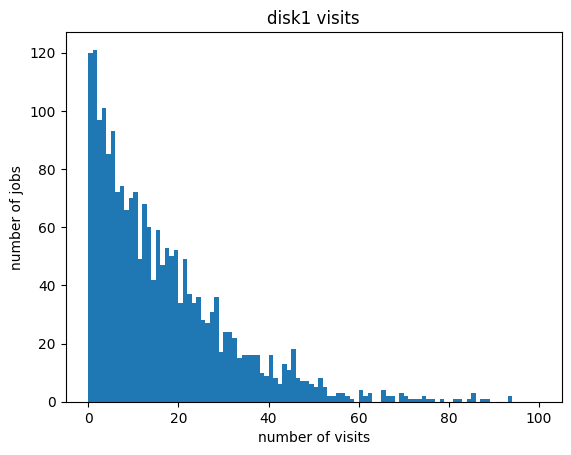

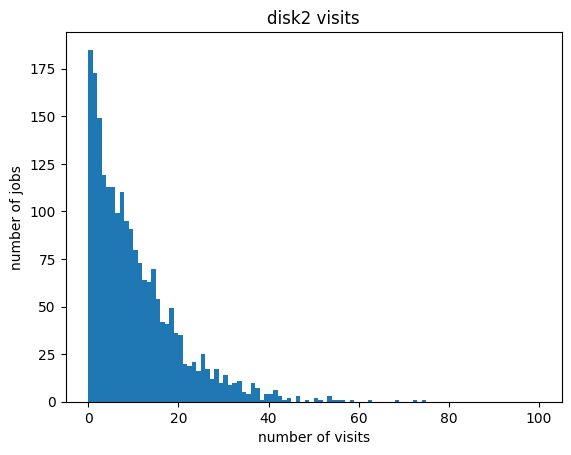

Num of jobs: 2356
Average Response Time in secods: 5.771
cpu utilization 0.855
disk1 utilization 0.786
disk2 utilization 0.587
avg waiting time: 2.173 in seconds
max waiting time: 22.24 in seconds
min waiting time: 0 in seconds


In [47]:
simul('FIFO', True, False)
# r = 0
# uc = 0
# ud = 0
# r_fifo = 0
# r_lwtf = 0
# r_lruf = 0
# uc_fifo = 0
# uc_lwtf = 0
# uc_lruf = 0
# ud_fifo = 0
# ud_lwtf = 0
# ud_lruf = 0
# n=15
# simul('FIFO', True, False)
# r, uc, ud = simul('FIFO', False, False)
# r_fifo += r
# uc_fifo += uc
# ud_fifo += ud
# r, uc, ud = simul('LWTF', False, False)
# r_lwtf+= r
# uc_lwtf += uc
# ud_lwtf += ud
# r, uc, ud = simul('LRUF', False, False)
# r_lruf+= r
# uc_lruf += uc
# ud_lruf += ud
# print("FIFO: R: ",  r_fifo/n, "U_cpu: ", uc_fifo/n, "U_disk: ", ud_fifo/n)
# print("LWTF: R:",  r_lwtf/n, "U_cpu: ", uc_lwtf/n, "U_disk: ", ud_lwtf/n)
# print("LRUF: R:", r_lruf/n, "U_cpu: ", uc_lruf/n, "U_disk: ", ud_lruf/n)